In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from dataset_PA1.dataloader import Dataloader
import time
from sklearn.metrics import confusion_matrix as sk_confusion_matrix

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [17]:
def softmax(x):
    exp_real = np.exp(x - np.max(x, axis=1, keepdims=True))
    pred = exp_real / np.sum(exp_real, axis=1, keepdims=True)
    return pred

def cross_entropy_loss(pred, ans):
    n = pred.shape[0]
    log_prob = np.log(pred[range(n), ans])
    loss = -np.sum(log_prob) / n
    return loss

def softmax_cross_entropy_backward(pred, ans):
    n = pred.shape[0]
    grad = pred - np.eye(pred.shape[1])[ans]
    grad = grad / n
    return grad

In [18]:
class PytorchThreeLayerCNN(nn.Module):
    def __init__(self):
        super(PytorchThreeLayerCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Linear(32*7*7, 128)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
data_path = './dataset_PA1'
learning_rate = 0.01
epochs = 100
batch_size = 64
train_loader = Dataloader(path=data_path, is_train=True, batch_size=batch_size)
test_loader = Dataloader(path=data_path, is_train=False, batch_size=batch_size)


input_size = 28 * 28
hidden_size1 = 128
hidden_size2 = 64
output_size = 10

In [ ]:
model_cnn = PytorchThreeLayerCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_cnn.parameters(), lr=learning_rate)

train_losses = []
test_accuracies = []
test_losses = []

for epoch in range(1, epochs + 1):
    start_time = time.time()
    model_cnn.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = torch.from_numpy(images).float().reshape(-1, 1, 28, 28)
        labels = torch.from_numpy(labels).float().argmax(dim=1)
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model_cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(images)
    train_losses.append(epoch_loss)

    model_cnn.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images = torch.from_numpy(images).float().view(-1, 1, 28, 28)
            labels = torch.from_numpy(labels).float().argmax(dim=1)

            outputs = model_cnn(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_test_loss = test_loss / len(images)
    test_losses.append(epoch_test_loss)
    accuracy = correct / total
    test_accuracies.append(accuracy)
    print(f"Epoch {epoch} completed in {time.time() - start_time:.2f}s - Train Loss: {epoch_loss:.4f}, Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {accuracy:.4f}")


Epoch 0 completed in 20.03s - Train Loss: 1500.8491, Test Loss: 216.1918, Test Accuracy: 0.8936


In [21]:
def plot_loss(train_losses, test_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

def get_top3(pred, image, label, num_class=10):
    fig, axes = plt.subplots(3, num_class, figsize=(20, 6))
    plt.suptitle("Top 3 Predicted Images for Each Class (3-Layer NN)")
    
    for i in range(num_class):
        scores = pred[:, i]
        top3_i = np.argsort(scores)[::-1][:3]
        
        
        for j, img_idx in enumerate(top3_i):
            
            score = scores[img_idx]

            pred_class = i
            real_class = label[img_idx]
            
            ax = axes[j, i]
            
            image_reshaped = image[img_idx].reshape(28, 28)
            ax.imshow(image_reshaped, cmap='gray')
            ax.axis('off')

            ax.set_title(f"{score:.2f}", fontsize=8) 
            
            if j == 0:
                ax.set_xlabel(f"Pred {pred_class}\nTrue {real_class}", fontsize=9, color='blue' if pred_class == real_class else 'red')
            else:
                ax.set_xlabel(f"True {real_class}", fontsize=9, color='blue' if pred_class == real_class else 'red')

            if i == 0:
                 ax.set_ylabel(f"Rank {j+1}", rotation=0, labelpad=15, fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()


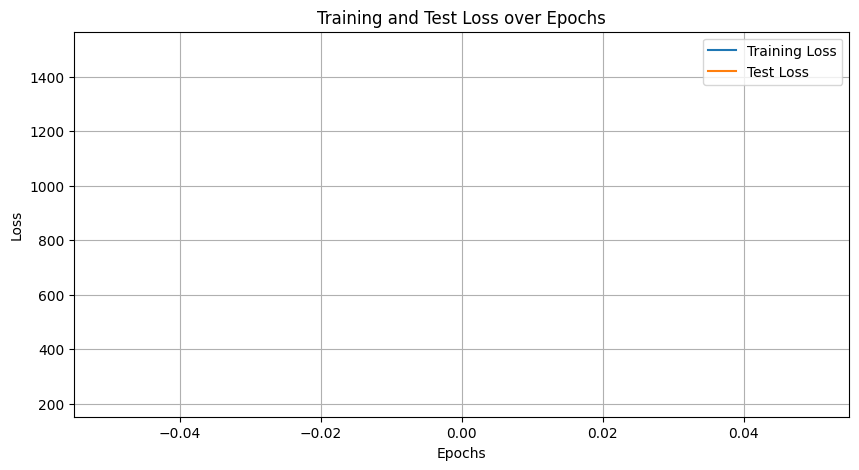

Confusion Matrix (sklearn):
[[ 950    0    9    5    0    4    8    1    2    1]
 [   0 1106   13    4    0    3    4    0    5    0]
 [   8    3  961   13   10    1   10   10   13    3]
 [   2    4   29  934    0   16    2    4    3   16]
 [   0    3   15    0  866    0    9    1    2   86]
 [  10   11   14   67   13  725   22    1   16   13]
 [  11    6   23    3   11   19  885    0    0    0]
 [   1   13   46    4    9    0    1  835    1  118]
 [   5   14   40   78   12   24   13    4  728   56]
 [   9    8    9   16   11    4    0    5    1  946]]
(10000,)

--- 클래스별 상위 3개 예측 --- (모델이 각 숫자로 가장 확신하는 이미지들)


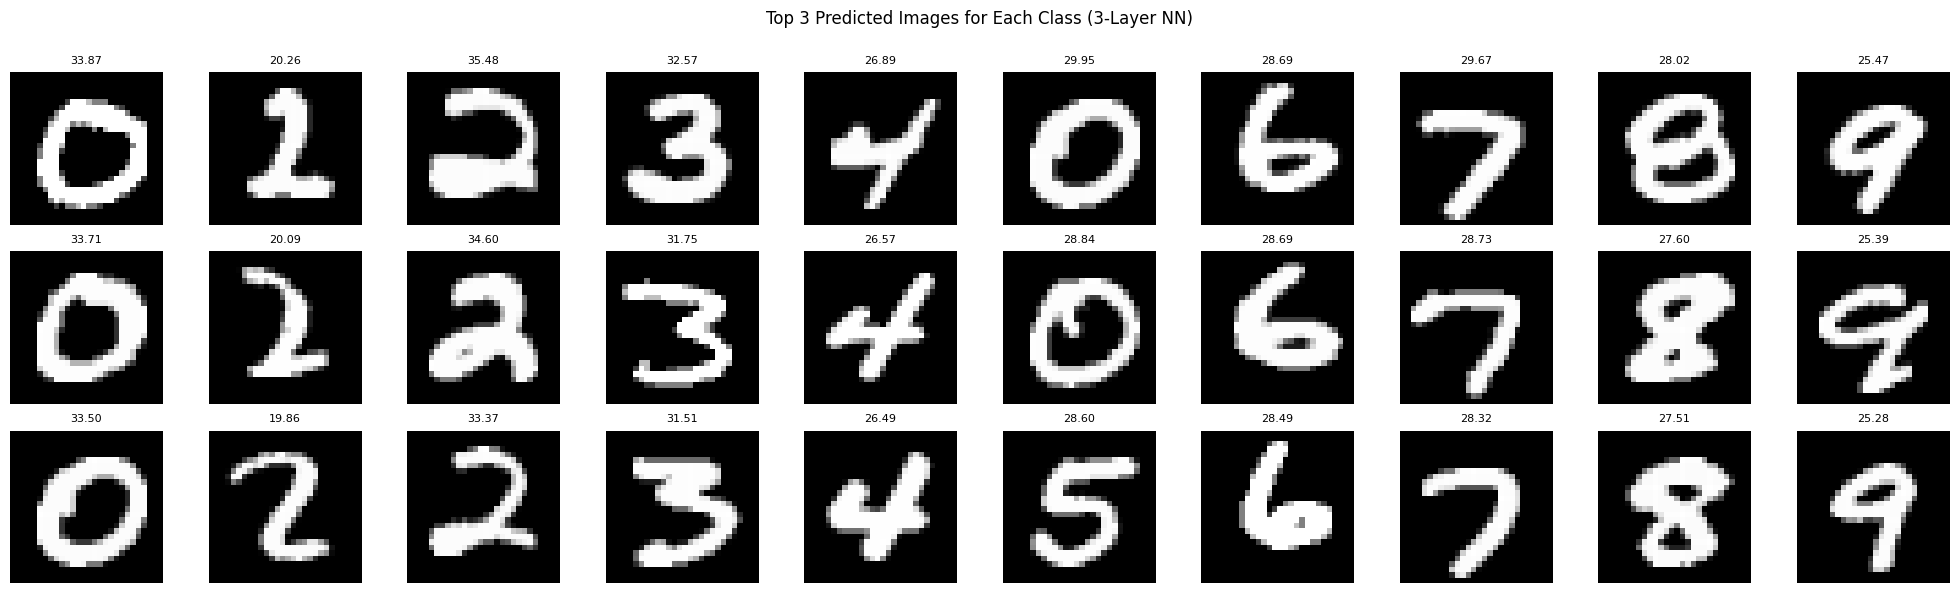

In [22]:
def predict_all(model, data_loader):
    model.eval()
    all_pred = []
    all_pred_score = []
    all_label = []
    
    with torch.no_grad():
        for image, label in data_loader:
            image_tensor = torch.from_numpy(image).float().view(-1, 1, 28, 28)
            outputs = model(image_tensor)

            _, predicted = torch.max(outputs.data, 1)
            all_pred.append(predicted)
            all_label.append(label)
            all_pred_score.append(outputs.data)
        final_pred = np.concatenate(all_pred, axis=0)
        final_label = np.concatenate(all_label, axis=0)
        final_pred_score = np.concatenate(all_pred_score, axis=0)
    return final_pred, final_label, final_pred_score

pred, gt, pred_score = predict_all(model_cnn, test_loader)

plot_loss(train_losses, test_losses)

conf_matrix = sk_confusion_matrix(gt.argmax(axis=1), pred)
print("Confusion Matrix (sklearn):")
print(conf_matrix)

# Load test data again to show predictions
test_images = []
test_labels = []
for image, label in test_loader:
    test_images.extend(image)
    
    label = np.argmax(label, axis=1)
    test_labels.extend(label)
    

test_images = np.concatenate(test_images, axis=0)
test_labels = np.array(test_labels)
print(test_labels.shape)
print("\n--- 클래스별 상위 3개 예측 --- (모델이 각 숫자로 가장 확신하는 이미지들)")
get_top3(pred_score, test_images, test_labels, num_class=10)